<a href="https://colab.research.google.com/github/Geebigib/Data-Science-Project/blob/main/Probability_Base_Model_separate_stage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyod --quiet

     |████████████████████████████████| 134 kB 5.3 MB/s 


In [3]:
!unzip /content/drive/MyDrive/SWaT_Dataset_v0.zip -d /content/

Archive:  /content/drive/MyDrive/SWaT_Dataset_v0.zip
  inflating: /content/SWaT_Dataset_Attack_v0.csv  
  inflating: /content/SWaT_Dataset_Normal_v0.csv  


In [4]:
import numpy as np
import os
import pandas as pd
from glob import glob
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import pickle
import tqdm
import matplotlib.pyplot as plt
from sklearn import metrics
import pyod
import seaborn as sns
import timeit
from sklearn.metrics import confusion_matrix

Data Pre-processing

In [5]:
swat_normal = pd.read_csv("SWaT_Dataset_Normal_v0.csv", skiprows=1)
swat_attack = pd.read_csv("SWaT_Dataset_Attack_v0.csv")

In [6]:
swat_normal.columns = swat_normal.columns.str.replace(' ','')
swat_attack.columns = swat_attack.columns.str.replace(' ','')

In [7]:
swat_attack["Normal/Attack"].replace(' ', '', regex=True, inplace=True)

In [8]:
test_df = swat_attack.set_index('Timestamp')
test_df['label'] = np.where(test_df['Normal/Attack'] == 'Attack', 1, 0)

test_df = test_df.drop('Normal/Attack', axis=1)

train_df = swat_normal.set_index('Timestamp')
train_df['label'] = np.where(train_df['Normal/Attack'] == 'Attack', 1, 0)
train_df = train_df.drop('Normal/Attack', axis=1)

# trim start stage
train_df = train_df.iloc[21600:]


In [9]:
train_df.drop(columns = 'label',inplace = True)
label = test_df['label'].values
test_df.drop(columns = 'label',inplace = True)

In [10]:
#normalise data
scaler = MinMaxScaler()
scaler = scaler.fit(train_df)

In [11]:
train_scale = pd.DataFrame(
    scaler.transform(train_df),
    index = train_df.index,
    columns= train_df.columns
)

test_scale  = pd.DataFrame(
    scaler.transform(test_df),
    index = test_df.index,
    columns= test_df.columns
)

In [12]:
train_scale.shape ,test_scale.shape

((475200, 51), (449919, 51))

In [13]:
train_df.columns

Index(['FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201', 'AIT202',
       'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205',
       'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303',
       'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401',
       'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502', 'AIT503', 'AIT504',
       'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501',
       'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603'],
      dtype='object')

In [14]:
P1 = ['FIT101', 'LIT101', 'MV101', 'P101', 'P102']
P2 = ['AIT201', 'AIT202','AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205', 'P206']
P3 = ['DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302']
P4 = ['AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401']
P5 = ['AIT501', 'AIT502', 'AIT503', 'AIT504','FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501',
       'PIT502', 'PIT503']
P6 = ['FIT601', 'P601', 'P602', 'P603']

Model Prediction on each stage

In [15]:
from  pyod.models.ecod import ECOD
model = ECOD(contamination=0.000000001)

In [16]:
def get_test_score(stage,train_scale,test_scale):
  norm_test_scores = []
  test_scores = []
  train_scores = []
  norm_train_scores = []
  trainning_time = []
  prediction_time = []

  for i in stage:
    model = ECOD(contamination=0.000000001)
    start = timeit.default_timer()
    model.fit(train_scale[i])
    end = timeit.default_timer()

    train_score = model.decision_scores_
    start_pred = timeit.default_timer()
    test_score = model.decision_function(test_scale[i])
    end_pred = timeit.default_timer()

    test_scores.append(test_score)
    train_scores.append(train_score)

    trainning_time.append(end-start)
    prediction_time.append(end_pred-start_pred)

    #normalise train&test score
    min_train = min(train_score)
    max_train = max(train_score)
    norm_train = (train_score-min_train)/(max_train-min_train)
    norm_test = (test_score - min_train)/(max_train-min_train)

    norm_test_scores.append(norm_test)
    norm_train_scores.append(norm_train)

    print(f"------ Finish Stage {i} ------")
  return norm_test_scores,test_scores,train_scores,norm_train_scores,trainning_time,prediction_time


In [17]:
stage = [P1,P2,P3,P4,P5,P6]

In [18]:
norm_test_scores,test_scores,train_scores,norm_train_scores,trainning_time,prediction_time = get_test_score(stage,train_scale,test_scale)

------ Finish Stage ['FIT101', 'LIT101', 'MV101', 'P101', 'P102'] ------
------ Finish Stage ['AIT201', 'AIT202', 'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205', 'P206'] ------
------ Finish Stage ['DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302'] ------
------ Finish Stage ['AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401'] ------
------ Finish Stage ['AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501', 'PIT502', 'PIT503'] ------
------ Finish Stage ['FIT601', 'P601', 'P602', 'P603'] ------


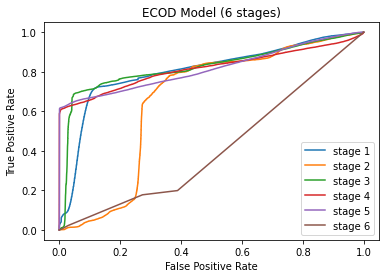

In [19]:
aucs = []
for i in range(len(norm_test_scores)):
  fpr, tpr, _ = metrics.roc_curve(label,  test_scores[i])
  auc = metrics.roc_auc_score(label,  test_scores[i])
  aucs.append(auc)
  plt.plot(fpr,tpr,label=f"stage {i+1}")
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.title(f'ECOD Model (6 stages)')
  plt.legend(loc=4)

In [20]:
for i in range(len(aucs)):
  print(f"AUC stage{i+1}: {np.round(aucs[i],3)}, training time = {trainning_time[i]}, prediction_time = {prediction_time[i]}")

AUC stage1: 0.805, training time = 1.651061406999986, prediction_time = 3.168683608000009
AUC stage2: 0.657, training time = 2.534494195999997, prediction_time = 5.497904210999991
AUC stage3: 0.824, training time = 2.306221726999979, prediction_time = 3.6665438309999843
AUC stage4: 0.818, training time = 1.253257001999998, prediction_time = 2.570253015999981
AUC stage5: 0.816, training time = 2.0317769250000026, prediction_time = 4.230135740999998
AUC stage6: 0.413, training time = 0.4816297099999929, prediction_time = 0.9274564929999656


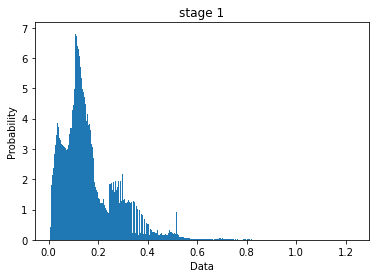

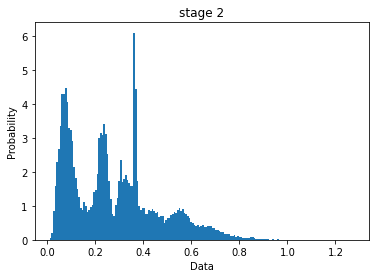

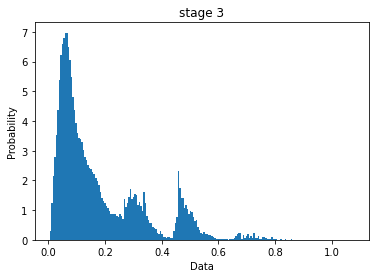

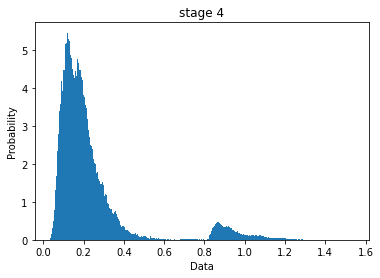

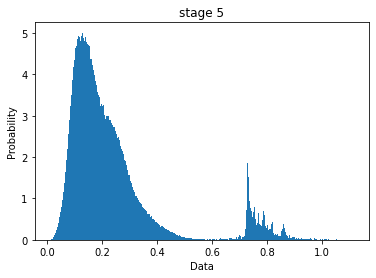

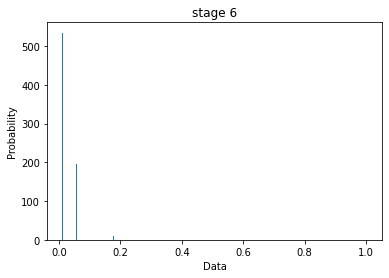

In [21]:
for i in range(len(norm_test_scores)):
  plt.hist(norm_test_scores[i], density=True, bins='auto')  # density=False would make counts
  plt.ylabel('Probability')
  plt.xlabel('Data')
  plt.title(f'stage {i+1}')
  plt.show()

In [22]:
def pred_labels_timewindow(df,threshold,time_window):
  n_data = len(df)
  pred_label = np.array([_ for _ in range(n_data)])
  for i in range(0,n_data-time_window+1):
    if (df[i:i+time_window] >= threshold).any():
      pred_label[i:i+time_window] = 1
    else:
      pred_label[i:i+time_window] = 0

  return pred_label

In [23]:
time_window = 1

##Ture Attack point

In [24]:
true_anomaly = pd.read_csv("/content/drive/MyDrive/Data_sci_Project/List_of_attacks_Final.csv")

In [25]:
true_attack = true_anomaly[~true_anomaly["End Time"].isnull()]

In [26]:
true_attack.tail(3)

,Attack #,Start Time,End Time,Attack Point,Start State,Attack,Actual Change,Expected Impact or attacker intent,Unexpected Outcome
38,39,2/01/2015 11:43:48,11:50:28,"FIT-401, AIT-502",In Normal Range,Set value of FIT-401 as 0.5; Set value of AIT-...,No,UV will shut down and water will go to RO,UV did not shutdown
39,40,2/01/2015 11:51:42,11:56:38,FIT-401,In Normal Range,Set value of FIT-401 as 0,No,UV will shut down and water will go to RO,"P-402 did not close, both should be interlinked"
40,41,2/01/2015 13:13:02,13:40:56,LIT-301,Water level between L and H,decrease value by 0.5 mm per second,No,Tank overflow,Rate of decrease in water level reduced after ...


In [27]:
start_time = true_attack['Start Time']
start_time = pd.to_datetime(start_time)
start_time.loc[36:40] = start_time.loc[36:40]+pd.DateOffset(years=1)

In [28]:
end_time = pd.to_datetime(true_anomaly['End Time'][~true_anomaly["End Time"].isnull()])

In [29]:
attack_lenght = (end_time - pd.to_datetime([str(a) for a in start_time.dt.time])).dt.seconds

In [30]:
len(start_time) #there are 36 attack

36

In [31]:
n_att = start_time.index.values+1
start_time.index.values+1

array([ 1,  2,  3,  4,  6,  7,  8, 10, 11, 13, 14, 16, 17, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41])

In [32]:
label

array([0, 0, 0, ..., 0, 0, 0])

In [33]:
time_label = pd.DataFrame(label, index =  test_df.index.values, columns = ["label"])
time_label.reset_index(inplace=True)
time_label.rename(columns = {'index':'Timestamp'}, inplace = True)
time_label['Timestamp'] = pd.to_datetime(time_label['Timestamp'])

In [34]:
time_label

,Timestamp,label
0,2015-12-28 10:00:00,0
1,2015-12-28 10:00:01,0
2,2015-12-28 10:00:02,0
3,2015-12-28 10:00:03,0
4,2015-12-28 10:00:04,0
...,...,...
449914,2016-02-01 14:59:55,0
449915,2016-02-01 14:59:56,0
449916,2016-02-01 14:59:57,0
449917,2016-02-01 14:59:58,0


In [35]:
#find start index/ end index of attack
idx_start = time_label[time_label['Timestamp'].isin(start_time)]['Timestamp'].index.values 
idx_end = idx_start+attack_lenght.values

In [36]:
idx_start

array([  1754,   3068,   4920,   6459,   7255,   7705,  11410,  15380,
        15540,  90685,  92140,  93445, 103092, 115843, 116143, 117000,
       132918, 142954, 172268, 172910, 198296, 227828, 229519, 279120,
       280060, 302653, 347679, 361191, 371479, 371855, 389680, 436541,
       437417, 438147, 438621, 443501])

In [37]:
time_label['attack #'] = 0
for i in range (len(n_att)):
  time_label['attack #'].loc[idx_start[i]:idx_end[i]] = n_att[i]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


##tunning threshold from stage P1

In [38]:
!pip install ghostml --quiet

In [39]:
import ghostml
n_percentile = [np.percentile(norm_test_scores,i) for i in range(95,100,1)]

In [40]:
threshold1 = ghostml.optimize_threshold_from_predictions(label, norm_test_scores[0], n_percentile, ThOpt_metrics = 'Kappa') 

In [41]:
threshold1

0.5430184044914178

In [42]:
n_percentile #use percentil 95

[0.5430184044914178,
 0.5977952603117432,
 0.70205805524962,
 0.7658072620141095,
 0.873483968111011]

##Stage P1

In [43]:
t1 = np.percentile(norm_test_scores[0],95)

In [44]:
label_1 = pred_labels_timewindow(norm_test_scores[0],t1,time_window)

In [45]:
time_label["pred_1"] = label_1

In [46]:
att_p1 = time_label[time_label['attack #'].isin([1,2,3,21,26,30,33,34,35,36])]

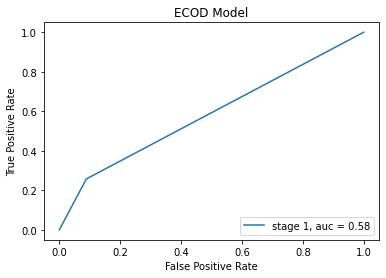

In [47]:
fpr, tpr, _ = metrics.roc_curve(label, label_1)
auc = metrics.roc_auc_score(label, label_1)
plt.plot(fpr,tpr,label=f"stage 1, auc = {np.round(auc,2)}")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title(f'ECOD Model')
plt.legend(loc=4)

In [48]:
print(metrics.classification_report(label,label_1))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90    395298
           1       0.29      0.26      0.27     54621

    accuracy                           0.83    449919
   macro avg       0.59      0.58      0.59    449919
weighted avg       0.82      0.83      0.83    449919



[[360211  35087]
 [ 40539  14082]]


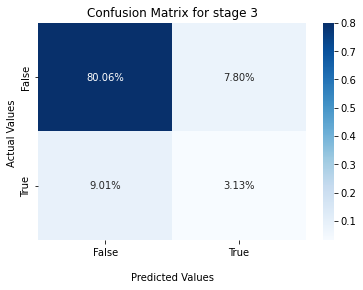

In [49]:
cm = confusion_matrix(label,label_1)
print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for stage 3');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [50]:
print(metrics.classification_report(att_p1.label,att_p1.pred_1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.72      0.84      6669

    accuracy                           0.72      6669
   macro avg       0.50      0.36      0.42      6669
weighted avg       1.00      0.72      0.84      6669



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
found = []
for i in range(len(att_p1)):
  if (att_p1.iloc[i]["pred_1"] == 1) & (att_p1.iloc[i]["label"] == 1):
    found.append(att_p1.iloc[i]["attack #"])
print(np.unique(found))

[ 1  2  3 26 30 33 34 35 36]


In [52]:
np.unique(att_p1["attack #"])

array([ 1,  2,  3, 21, 26, 30, 33, 34, 35, 36])

##Stage P2

In [53]:
t2 = np.percentile(norm_test_scores[1],95)

In [54]:
t2

0.6327029702186139

In [55]:
label_2 = pred_labels_timewindow(norm_test_scores[1],t2,time_window)

In [56]:
print(metrics.classification_report(label,label_2))

              precision    recall  f1-score   support

           0       0.87      0.94      0.91    395298
           1       0.04      0.02      0.02     54621

    accuracy                           0.83    449919
   macro avg       0.46      0.48      0.46    449919
weighted avg       0.77      0.83      0.80    449919



[[371142  24156]
 [ 53705    916]]


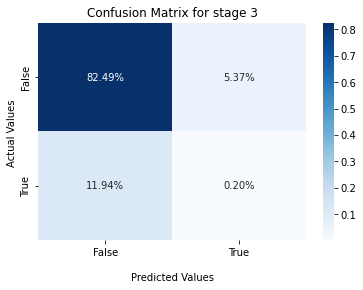

In [57]:
cm = confusion_matrix(label,label_2)
print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for stage 3');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [58]:
time_label["pred_2"] = label_2

In [59]:
att_p2 = time_label[time_label['attack #'].isin([6,24,29])]

In [60]:
found = []
for i in range(len(att_p2)):
  if (att_p2.iloc[i]["pred_2"] == 1) & (att_p2.iloc[i]["label"] == 1):
    found.append(att_p2.iloc[i]["attack #"])
print(np.unique(found))

[24]


In [61]:
print(metrics.classification_report(att_p2.label,att_p2.pred_2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.09      0.16       638

    accuracy                           0.09       638
   macro avg       0.50      0.04      0.08       638
weighted avg       1.00      0.09      0.16       638



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Stage P3

In [62]:
t3 = np.percentile(norm_test_scores[2],95)

In [63]:
t3

0.5003064776799223

In [64]:
label_3 = pred_labels_timewindow(norm_test_scores[2],t3,time_window)

In [65]:
print(metrics.classification_report(label,label_3))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94    395298
           1       0.64      0.42      0.51     54621

    accuracy                           0.90    449919
   macro avg       0.78      0.69      0.73    449919
weighted avg       0.89      0.90      0.89    449919



[[382368  12930]
 [ 31730  22891]]


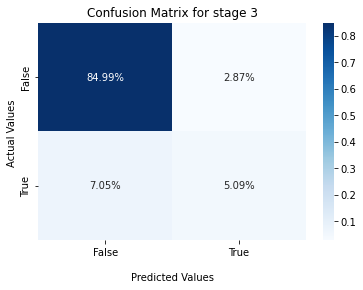

In [66]:
cm = confusion_matrix(label,label_3)
print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for stage 3');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [67]:
time_label["pred_3"] = label_3

In [68]:
att_p3 = time_label[time_label['attack #'].isin([7,8,13,14,16,17,23,26,27,28,32,41])]

In [69]:
found = []
for i in range(len(att_p3)):
  if (att_p3.iloc[i]["pred_3"] == 1) & (att_p3.iloc[i]["label"] == 1):
    found.append(att_p3.iloc[i]["attack #"])
print(np.unique(found))

[ 8 17 23 26 28 41]


In [70]:
print(metrics.classification_report(att_p3.label,att_p3.pred_3))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.52      0.68     43368

    accuracy                           0.52     43368
   macro avg       0.50      0.26      0.34     43368
weighted avg       1.00      0.52      0.68     43368



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Stage P4

In [71]:
t4 = np.percentile(norm_test_scores[3],95)

In [72]:
t4

0.8815313857317895

In [73]:
label_4 = pred_labels_timewindow(norm_test_scores[3],t4,time_window)

In [74]:
print(metrics.classification_report(label,label_4))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97    395298
           1       1.00      0.50      0.66     54621

    accuracy                           0.94    449919
   macro avg       0.97      0.75      0.81    449919
weighted avg       0.94      0.94      0.93    449919



[[395192    106]
 [ 27554  27067]]


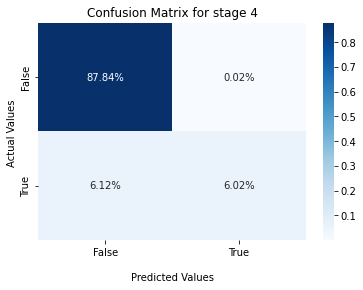

In [75]:
cm = confusion_matrix(label,label_4)
print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for stage 4');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [76]:
time_label["pred_4"] = label_4

In [77]:
att_p4 = time_label[time_label['attack #'].isin([10,11,22,25,31,38,39,40])]

In [78]:
found = []
for i in range(len(att_p4)):
  if (att_p4.iloc[i]["pred_4"] == 1) & (att_p4.iloc[i]["label"] == 1):
    found.append(att_p4.iloc[i]["attack #"])
print(np.unique(found))

[]


In [79]:
print(metrics.classification_report(att_p4.label,att_p4.pred_4))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00    3142.0

    accuracy                           0.00    3142.0
   macro avg       0.00      0.00      0.00    3142.0
weighted avg       0.00      0.00      0.00    3142.0



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

##Stage P5

In [80]:
t5 = np.percentile(norm_test_scores[4],95)

In [81]:
t5

0.74094302851048

In [82]:
label_5 = pred_labels_timewindow(norm_test_scores[4],t5,time_window)

In [83]:
print(metrics.classification_report(label,label_5))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96    395298
           1       0.99      0.44      0.61     54621

    accuracy                           0.93    449919
   macro avg       0.96      0.72      0.79    449919
weighted avg       0.94      0.93      0.92    449919



[[395106    192]
 [ 30390  24231]]


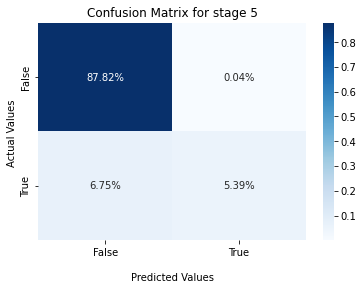

In [84]:
cm = confusion_matrix(label,label_5)
print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for stage 5');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [85]:
time_label["pred_5"] = label_5

In [86]:
att_p5 = time_label[time_label['attack #'].isin([4,19,20,22,37,38,39])]

In [87]:
found = []
for i in range(len(att_p5)):
  if (att_p5.iloc[i]["pred_5"] == 1) & (att_p5.iloc[i]["label"] == 1):
    found.append(att_p5.iloc[i]["attack #"])
print(np.unique(found))

[22 37]


In [88]:
print(metrics.classification_report(att_p5.label,att_p5.pred_5))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.06      0.11      2658

    accuracy                           0.06      2658
   macro avg       0.50      0.03      0.06      2658
weighted avg       1.00      0.06      0.11      2658



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Stage P6

In [89]:
t6 = np.percentile(norm_test_scores[5],98)

In [90]:
t6

0.177549398921028

In [91]:
label_6 = pred_labels_timewindow(norm_test_scores[5],t6,time_window)

In [92]:
print(metrics.classification_report(label,label_6))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92    395298
           1       0.10      0.03      0.05     54621

    accuracy                           0.85    449919
   macro avg       0.49      0.50      0.48    449919
weighted avg       0.78      0.85      0.81    449919



[[379733  15565]
 [ 52861   1760]]


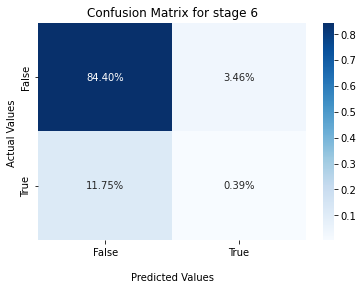

In [93]:
cm = confusion_matrix(label,label_6)
print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for stage 6');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [94]:
time_label["pred_6"] = label_6

In [95]:
att_p6 = time_label[time_label['attack #'].isin([23])]

In [96]:
found = []
for i in range(len(att_p6)):
  if (att_p6.iloc[i]["pred_6"] == 1) & (att_p6.iloc[i]["label"] == 1):
    found.append(att_p6.iloc[i]["attack #"])
print(np.unique(found))

[23]


In [97]:
print(metrics.classification_report(att_p6.label,att_p6.pred_6))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.05      0.09       697

    accuracy                           0.05       697
   macro avg       0.50      0.02      0.04       697
weighted avg       1.00      0.05      0.09       697



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  0   0]
 [665  32]]


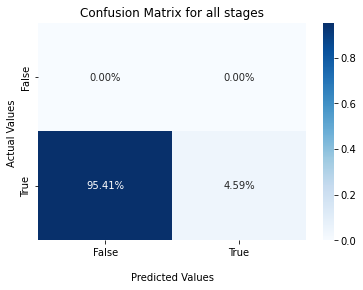

In [98]:
cm = confusion_matrix(att_p6.label,att_p6.pred_6)

print(cm)
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for all stages');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

##Attack found

In [99]:
time_label['pred'] = np.where((time_label['pred_1'] ==1) | 
                              (time_label['pred_2'] ==1) |
                              (time_label['pred_3'] ==1) |
                              (time_label['pred_4'] ==1) |
                              (time_label['pred_5'] ==1) |
                              (time_label['pred_6'] ==1), 1, 0)


In [100]:
time_label[time_label["label"] == 1].tail(5)

,Timestamp,label,attack #,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred
445186,2016-02-01 13:41:07,1,0,0,0,1,0,0,0,1
445187,2016-02-01 13:41:08,1,0,0,0,1,0,0,0,1
445188,2016-02-01 13:41:09,1,0,0,0,1,0,0,0,1
445189,2016-02-01 13:41:10,1,0,0,0,1,0,0,0,1
445190,2016-02-01 13:41:11,1,0,0,0,1,0,0,0,1


In [101]:
found = []
for i in (n_att):
  idx_found = time_label[(time_label["pred"] == 1) & (time_label["label"] == 1) & (time_label["attack #"] == i)].index.values
  if len(idx_found) >= 100:
    found.append(time_label.iloc[i]["attack #"])
print(np.unique(found))

[ 0  1  2  3  4  8 11 13 17 19 21 22 23 24 25 26 27 28 29 30 31 32 33 34
 35 36 37 38 39 40 41]


In [102]:
len(np.unique(found))-1 #remove 0

30

In [103]:
print(metrics.classification_report(time_label.label,time_label.pred))

              precision    recall  f1-score   support

           0       0.96      0.81      0.88    395298
           1       0.36      0.77      0.49     54621

    accuracy                           0.81    449919
   macro avg       0.66      0.79      0.69    449919
weighted avg       0.89      0.81      0.83    449919



In [104]:
cm = confusion_matrix(time_label.label,time_label.pred)

print(cm)

[[320716  74582]
 [ 12687  41934]]


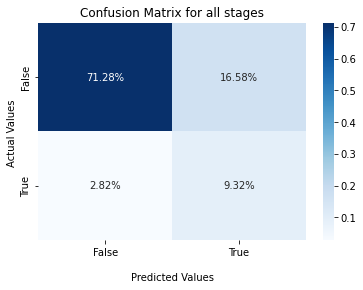

In [105]:
ax = sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for all stages');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

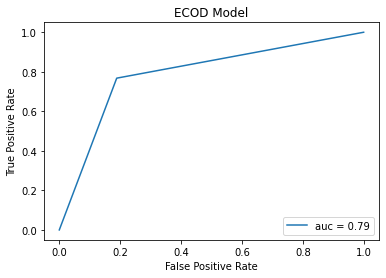

In [106]:
fpr, tpr, _ = metrics.roc_curve(time_label.label,time_label.pred)
auc = metrics.roc_auc_score(time_label.label,time_label.pred)
plt.plot(fpr,tpr,label=f"auc = {np.round(auc,2)}")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title(f'ECOD Model')
plt.legend(loc=4)

Find explanation for undetect attack

#XAI

In [107]:
att_found = np.unique(found)
att_found

array([ 1,  2,  3,  4,  8, 11, 13, 17, 19, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41])

In [108]:
!pip install shap --quiet
!pip install lime --quiet
!pip install alibi[tensorflow] --quiet

     |████████████████████████████████| 569 kB 5.1 MB/s 
     |████████████████████████████████| 275 kB 5.4 MB/s 
     |████████████████████████████████| 445 kB 5.2 MB/s 
     |████████████████████████████████| 60 kB 7.1 MB/s 
     |████████████████████████████████| 4.7 MB 65.6 MB/s 
     |████████████████████████████████| 98.5 MB 111 kB/s 
     |████████████████████████████████| 101 kB 10.8 MB/s 
     |████████████████████████████████| 6.6 MB 36.9 MB/s 


In [109]:
import shap
import lime
import lime.lime_tabular
from lime import submodular_pick
from alibi.explainers import ALE

In [110]:
X_train_summary = shap.kmeans(train_scale, 100)
shap_explainer = shap.KernelExplainer(model=model.decision_function, data=X_train_summary)
ale = ALE(model.decision_function, feature_names=train_scale.columns)
lm = lime.lime_tabular.LimeTabularExplainer(X_train_summary.data, feature_names=train_scale.columns,
                                                   verbose=True, mode='regression')

In [111]:
def explain_all_attack(att_found,test_scale):
  shap_values = []
  limes = []
  ales = []
  for i in att_found:
    idx = time_label[(time_label["attack #"] == i)].index.values
    n = 100 if len(idx) > 100 else len(idx)
    sample = test_scale[idx[0]:idx[-1]].sample(n = n)
    #shap explainer
    shap_value = shap_explainer.shap_values(X=sample, nsamples=100)
    shap_values.append(np.mean(shap_value,axis=0))

    #lime
    sp_obj = submodular_pick.SubmodularPick(lm, sample.values, model.decision_function, num_features=20,num_exps_desired=1)
    limes.append(sp_obj.sp_explanations[0].as_list())

    #ale
    exp_ale = ale.explain(sample.to_numpy())
    ales.append([np.mean(e) for e in exp_ale.ale_values])

    print(f"---------------------------------- finish XAI attack no {i} ----------------------------")
  
  return shap_values,limes,ales

In [112]:
shap_values,limes,ales = explain_all_attack(att_found,test_scale)

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 66.4613991153549
Prediction_local [55.1519085]
Right: 124.79350673289989
Intercept 64.85538200113845
Prediction_local [58.33344325]
Right: 132.975691925193
Intercept 66.292352181241
Prediction_local [57.97551114]
Right: 144.70625233297739
Intercept 65.1605528981887
Prediction_local [57.54050171]
Right: 142.2464620103364
Intercept 64.88629889360597
Prediction_local [61.17506575]
Right: 123.16674695972755
Intercept 64.68986033670056
Prediction_local [57.79243637]
Right: 142.56577500411203
Intercept 63.72652695177752
Prediction_local [60.55010667]
Right: 145.36933459195575
Intercept 66.22329130281149
Prediction_local [56.533159]
Right: 154.90675796340534
Intercept 65.41001105046513
Prediction_local [58.240421]
Right: 146.94330314317392
Intercept 66.39068766903937
Prediction_local [56.19050376]
Right: 133.76195851935012
Intercept 65.38556548973105
Prediction_local [58.33873005]
Right: 131.85989481167127
Intercept 66.9754224257016
Prediction_local [54.79242502]
Right: 135.05482353

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 65.06164344574499
Prediction_local [102.64564211]
Right: 148.30906673648832
Intercept 66.22223033374965
Prediction_local [94.51739308]
Right: 134.65795993919534
Intercept 61.42862967431107
Prediction_local [97.56959638]
Right: 138.6526778401625
Intercept 67.93077468215567
Prediction_local [96.52837133]
Right: 142.78748357187607
Intercept 65.27682418191249
Prediction_local [90.5950514]
Right: 124.1827750997143
Intercept 67.16401744021007
Prediction_local [97.08451059]
Right: 140.42758257680327
Intercept 62.424898125173364
Prediction_local [104.71911177]
Right: 147.93576742448906
Intercept 67.13796574267145
Prediction_local [101.28623613]
Right: 149.5113412498282
Intercept 66.61998797021317
Prediction_local [101.23805071]
Right: 149.6883015770154
Intercept 54.995688166189794
Prediction_local [113.48565881]
Right: 160.02389716338507
Intercept 59.881449730063835
Prediction_local [97.9628154]
Right: 136.55306999032453
Intercept 64.52070341851028
Prediction_local [101.18359918]
Rig

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 64.40228873832513
Prediction_local [60.96773289]
Right: 107.93147273836671
Intercept 65.04218176299804
Prediction_local [59.24837374]
Right: 118.76923203165704
Intercept 63.81429411456199
Prediction_local [61.92966115]
Right: 116.99993622438284
Intercept 64.70214075199739
Prediction_local [58.04489713]
Right: 121.67436914801694
Intercept 65.52903537351543
Prediction_local [59.31060982]
Right: 108.07459057200533
Intercept 65.07697568920352
Prediction_local [60.21434495]
Right: 99.78872612676241
Intercept 64.98815396409029
Prediction_local [59.6251409]
Right: 108.75494576651704
Intercept 65.80165458249672
Prediction_local [59.5301535]
Right: 100.54745790568683
Intercept 65.02512322391217
Prediction_local [57.62572107]
Right: 108.07616274844406
Intercept 64.11292571872829
Prediction_local [62.58763409]
Right: 106.97291778865252
Intercept 62.97973700438266
Prediction_local [63.84804097]
Right: 110.83039836056014
Intercept 63.395801824299234
Prediction_local [64.19692677]
Right: 1

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 65.61738948297497
Prediction_local [57.57568284]
Right: 136.34120782989646
Intercept 63.99843259730231
Prediction_local [61.1572634]
Right: 137.0650147532293
Intercept 64.03461288795928
Prediction_local [60.59451122]
Right: 149.21325382893681
Intercept 65.85524312421451
Prediction_local [57.98495869]
Right: 131.39114090220286
Intercept 63.51915645358618
Prediction_local [62.46366721]
Right: 129.970008356433
Intercept 65.81354598431746
Prediction_local [58.10758864]
Right: 134.45031503079502
Intercept 66.82228433707552
Prediction_local [56.05240563]
Right: 131.44987049360589
Intercept 65.72385927128457
Prediction_local [55.74082401]
Right: 134.5331328059391
Intercept 65.83807097032687
Prediction_local [56.31713928]
Right: 134.22245771577377
Intercept 66.76606157388753
Prediction_local [56.04758983]
Right: 134.04174166390135
Intercept 65.30279008546111
Prediction_local [57.70864258]
Right: 142.44273608299878
Intercept 66.79686325489519
Prediction_local [56.1334008]
Right: 128.3

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 53.42119153223313
Prediction_local [72.20116889]
Right: 173.23166469616527
Intercept 51.30658920916686
Prediction_local [77.78155765]
Right: 179.53572325753012
Intercept 52.790121163087036
Prediction_local [73.93072114]
Right: 137.8120704835542
Intercept 61.73486104780886
Prediction_local [65.40796996]
Right: 141.33238872275896
Intercept 59.35922982735025
Prediction_local [68.69813093]
Right: 164.64142731480948
Intercept 61.29407402475645
Prediction_local [66.70648648]
Right: 155.57480795787194
Intercept 61.30902752000462
Prediction_local [64.74017863]
Right: 148.8379900909844
Intercept 56.78633120654649
Prediction_local [70.10946473]
Right: 133.70288284412274
Intercept 55.19235353995216
Prediction_local [72.26172791]
Right: 151.87827481347986
Intercept 57.8053095976519
Prediction_local [69.93419959]
Right: 144.49244160504412
Intercept 60.74403598451185
Prediction_local [65.95455572]
Right: 158.05153401449263
Intercept 58.409883961393504
Prediction_local [68.69759752]
Right: 

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 61.30893710834293
Prediction_local [66.18669496]
Right: 217.53754216734748
Intercept 63.279839698880494
Prediction_local [63.16186921]
Right: 211.15456057720687
Intercept 63.45101505854687
Prediction_local [64.44706645]
Right: 209.69111712794742
Intercept 62.640939918204886
Prediction_local [63.55502599]
Right: 216.64676903636766
Intercept 62.94881108271397
Prediction_local [64.21500723]
Right: 215.86026824979578
Intercept 62.41680191499591
Prediction_local [64.21441465]
Right: 221.58601712438357
Intercept 63.23015409374544
Prediction_local [62.75870147]
Right: 219.8096472156783
Intercept 63.251067991837814
Prediction_local [66.07316995]
Right: 210.55011137393123
Intercept 61.14347493905663
Prediction_local [65.55210903]
Right: 212.69533303090515
Intercept 63.63980306397634
Prediction_local [62.59996503]
Right: 196.7191218636479
Intercept 63.956814828580306
Prediction_local [63.41284108]
Right: 209.74641452003462
Intercept 63.698975157472994
Prediction_local [64.06812991]
Rig

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 67.96386285170729
Prediction_local [51.46480655]
Right: 126.01147586522063
Intercept 67.21915377042524
Prediction_local [51.98901369]
Right: 125.98251303232091
Intercept 68.28660662591271
Prediction_local [50.07320744]
Right: 118.19357752313873
Intercept 66.01880768519358
Prediction_local [54.58537022]
Right: 125.16918515972772
Intercept 68.40637107848134
Prediction_local [48.77290574]
Right: 118.52453804396181
Intercept 67.64039034760866
Prediction_local [52.47661906]
Right: 127.10556068584216
Intercept 66.99987783527601
Prediction_local [51.94657611]
Right: 125.14727102630128
Intercept 66.44954252015928
Prediction_local [53.35852946]
Right: 126.19160216176311
Intercept 68.50644425948164
Prediction_local [49.5889016]
Right: 119.19206786329686
Intercept 67.88155456103446
Prediction_local [50.59361675]
Right: 116.33360743339341
Intercept 65.5952777711551
Prediction_local [54.82138538]
Right: 127.86293444784945
Intercept 66.8178443277505
Prediction_local [53.73767091]
Right: 11

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 62.61211599502263
Prediction_local [58.02543873]
Right: 125.99410050228859
Intercept 67.02034032425954
Prediction_local [51.66325802]
Right: 130.76164284218393
Intercept 61.97768388752762
Prediction_local [62.39274082]
Right: 110.04246845295289
Intercept 62.446197792952134
Prediction_local [59.9736706]
Right: 112.3008496709344
Intercept 66.08831616501908
Prediction_local [52.65142599]
Right: 130.31437321286455
Intercept 53.787037039531384
Prediction_local [72.40476981]
Right: 134.77970424398424
Intercept 62.520077926175155
Prediction_local [59.68289792]
Right: 127.78646068717391
Intercept 62.167685424896874
Prediction_local [59.10192607]
Right: 125.97359046453398
Intercept 61.84721387032581
Prediction_local [58.35672708]
Right: 126.11412297784723
Intercept 61.164232220907685
Prediction_local [63.11949815]
Right: 116.07911369379102
Intercept 61.77179134433946
Prediction_local [61.78026336]
Right: 109.01405669772308
Intercept 62.32992635900796
Prediction_local [59.35807406]
Rig

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 63.508644456204294
Prediction_local [62.27895895]
Right: 153.69365774287604
Intercept 61.324193354983294
Prediction_local [62.80889765]
Right: 143.17293123682197
Intercept 63.548239266109725
Prediction_local [64.84789818]
Right: 153.13625695508767
Intercept 63.06384937792031
Prediction_local [62.38244621]
Right: 153.82265919449154
Intercept 57.43636289820562
Prediction_local [67.13012706]
Right: 166.80102974076027
Intercept 58.974342496060125
Prediction_local [68.44835606]
Right: 159.6804093515939
Intercept 58.74521013804703
Prediction_local [67.74987011]
Right: 151.45870679294404
Intercept 52.110706919092344
Prediction_local [76.6667344]
Right: 173.80936547113157
Intercept 64.81464329142598
Prediction_local [61.76752503]
Right: 153.6963622143854
Intercept 64.97353386329965
Prediction_local [61.08617573]
Right: 146.2037008657645
Intercept 64.4105428347098
Prediction_local [60.92577382]
Right: 148.9686299895139
Intercept 57.7141067855738
Prediction_local [70.24247336]
Right: 1

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 63.226073916117734
Prediction_local [64.48784363]
Right: 150.51312420976063
Intercept 63.531940265040255
Prediction_local [62.55719885]
Right: 144.02203109108612
Intercept 63.011378685100325
Prediction_local [62.84175014]
Right: 139.18603287715175
Intercept 63.57216634625371
Prediction_local [62.35931788]
Right: 154.32532869150307
Intercept 63.316675676251926
Prediction_local [63.00502269]
Right: 155.7168108346637
Intercept 64.30216895375004
Prediction_local [62.95006414]
Right: 137.90379234288767
Intercept 63.02287763897232
Prediction_local [64.78681513]
Right: 150.71475033296215
Intercept 65.5417337115109
Prediction_local [60.77843778]
Right: 137.95434846685606
Intercept 63.77206221763137
Prediction_local [60.87915722]
Right: 143.73071081081713
Intercept 62.995217875732514
Prediction_local [64.43640714]
Right: 146.98091181074648
Intercept 63.96502244198391
Prediction_local [62.65010123]
Right: 145.8227781618065
Intercept 63.145541336104266
Prediction_local [64.47141177]
Rig

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 63.61859463152945
Prediction_local [63.48687149]
Right: 209.129585209718
Intercept 63.70927657925608
Prediction_local [61.59087058]
Right: 214.35857383681983
Intercept 63.78540242535805
Prediction_local [63.56545106]
Right: 214.26877317102785
Intercept 64.23993219484997
Prediction_local [63.75813757]
Right: 219.83928922957514
Intercept 64.00493480347518
Prediction_local [61.55230809]
Right: 222.75994537393083
Intercept 63.63428517008029
Prediction_local [65.07945925]
Right: 215.56451188357767
Intercept 63.346915799092486
Prediction_local [64.42025912]
Right: 207.4055716499936
Intercept 64.02305957893827
Prediction_local [64.9793582]
Right: 215.17137135438287
Intercept 62.828985197684105
Prediction_local [64.77910659]
Right: 217.09240265104063
Intercept 63.01924783391057
Prediction_local [64.51800782]
Right: 208.60848392734047
Intercept 63.16435038259948
Prediction_local [64.71256706]
Right: 205.61419708921187
Intercept 64.15675431971451
Prediction_local [62.54380437]
Right: 2

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 64.49635029802984
Prediction_local [61.22209111]
Right: 153.82101447401703
Intercept 62.92936083070283
Prediction_local [64.23812496]
Right: 154.10096484192002
Intercept 63.93750565600036
Prediction_local [64.48533672]
Right: 152.33212750217177
Intercept 62.0576825726622
Prediction_local [66.24543275]
Right: 168.96768059918517
Intercept 64.83208525177032
Prediction_local [64.1133817]
Right: 155.35656434316584
Intercept 64.74744685087947
Prediction_local [60.83412513]
Right: 154.4822449073508
Intercept 64.07968819883367
Prediction_local [64.59203434]
Right: 162.09870445587555
Intercept 63.54015202990147
Prediction_local [61.08055151]
Right: 155.0691115964339
Intercept 64.67993870690975
Prediction_local [60.92228507]
Right: 144.10925287448487
Intercept 61.88476925309847
Prediction_local [64.81034417]
Right: 162.36459373345477
Intercept 63.9538414267642
Prediction_local [60.99338259]
Right: 162.60533229692248
Intercept 63.92444797267862
Prediction_local [61.12194792]
Right: 168.

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 66.6311235734283
Prediction_local [56.87699553]
Right: 122.04526236725671
Intercept 66.48048976486754
Prediction_local [58.71550793]
Right: 126.61378300777217
Intercept 66.24857044208541
Prediction_local [57.11941602]
Right: 129.87959752517398
Intercept 66.6285171647133
Prediction_local [57.20909334]
Right: 130.8172800000971
Intercept 65.05790538498955
Prediction_local [60.12534067]
Right: 129.2625484976532
Intercept 65.15016089779381
Prediction_local [60.64344803]
Right: 126.80447535273068
Intercept 67.65614689064908
Prediction_local [116.70619622]
Right: 149.11918272047555
Intercept 67.5398341127579
Prediction_local [119.48514991]
Right: 152.01597221887408
Intercept 66.4190851192483
Prediction_local [55.87561806]
Right: 128.96846904450817
Intercept 66.76939977429876
Prediction_local [121.61989668]
Right: 155.63391168534136
Intercept 66.27057477066884
Prediction_local [116.48455444]
Right: 147.44903383970896
Intercept 65.86235460473515
Prediction_local [58.79748278]
Right: 1

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 64.57459567661974
Prediction_local [62.87280259]
Right: 141.6762268236475
Intercept 64.17459833500665
Prediction_local [62.52020134]
Right: 144.67065812548043
Intercept 63.812376554641695
Prediction_local [62.94340689]
Right: 138.26134650099848
Intercept 64.65015231982902
Prediction_local [62.0460982]
Right: 136.44307240626281
Intercept 62.88930727752196
Prediction_local [64.74525142]
Right: 137.27102069738655
Intercept 64.71652493587804
Prediction_local [60.87436712]
Right: 133.63537564923544
Intercept 65.65297503665369
Prediction_local [62.49457969]
Right: 139.64554133361224
Intercept 64.19880935219909
Prediction_local [61.41119964]
Right: 134.53173543296117
Intercept 66.07572874703631
Prediction_local [59.73008084]
Right: 139.86891694603898
Intercept 62.11816055014026
Prediction_local [66.72131646]
Right: 138.44874410589165
Intercept 63.97599200573335
Prediction_local [60.78849591]
Right: 138.64290084666746
Intercept 66.27914306932117
Prediction_local [59.12396002]
Right: 

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 65.35847854979491
Prediction_local [134.55754565]
Right: 208.35128745780617
Intercept 63.57316295831308
Prediction_local [137.29181315]
Right: 212.0766933714038
Intercept 64.75656549542866
Prediction_local [132.21969832]
Right: 205.10368511436175
Intercept 66.44099591191271
Prediction_local [137.75823714]
Right: 218.32735799066674
Intercept 64.65658370527586
Prediction_local [134.7363311]
Right: 209.03333738401707
Intercept 63.57211703271959
Prediction_local [143.59011822]
Right: 223.2664272860896
Intercept 64.1854501880683
Prediction_local [145.59586637]
Right: 228.31681339098012
Intercept 64.1951335150254
Prediction_local [135.36911892]
Right: 209.88598943738018
Intercept 63.953106791874404
Prediction_local [136.99226434]
Right: 212.4014727005931
Intercept 64.2686748244244
Prediction_local [130.27150662]
Right: 201.78066495396158
Intercept 65.41060193943808
Prediction_local [135.73146884]
Right: 212.83760606856833
Intercept 66.10669418493045
Prediction_local [132.79251017]


  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 63.5758412916584
Prediction_local [66.05894962]
Right: 170.28604304217973
Intercept 63.87549539478992
Prediction_local [61.06847572]
Right: 161.0613228036241
Intercept 63.95929912484207
Prediction_local [62.64624614]
Right: 166.55425878851418
Intercept 62.7701141663807
Prediction_local [63.28337188]
Right: 172.69698844530987
Intercept 65.60589047276316
Prediction_local [59.60910161]
Right: 162.79654008595872
Intercept 63.022329079660686
Prediction_local [64.2941746]
Right: 167.59625425864562
Intercept 64.61955808146385
Prediction_local [61.86009374]
Right: 177.72162932208013
Intercept 62.693808305274096
Prediction_local [63.56035018]
Right: 162.70129275316907
Intercept 63.05831628074246
Prediction_local [64.15575456]
Right: 177.42860148930546
Intercept 63.53997963640187
Prediction_local [64.0354936]
Right: 172.83340084771802
Intercept 62.76275808999334
Prediction_local [64.07273139]
Right: 162.12723506785932
Intercept 61.93566783359335
Prediction_local [64.49731248]
Right: 18

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 59.99418362558175
Prediction_local [68.29387252]
Right: 163.6460514109625
Intercept 58.52418060341409
Prediction_local [70.22820095]
Right: 230.3340558374659
Intercept 59.59514984713489
Prediction_local [69.48999978]
Right: 229.82916859238995
Intercept 58.376092454291026
Prediction_local [70.50367627]
Right: 232.00466832786418
Intercept 58.32024975450309
Prediction_local [71.67249654]
Right: 228.99342884689787
Intercept 59.86461836289446
Prediction_local [70.33881344]
Right: 229.42455034378537
Intercept 59.98896457066114
Prediction_local [68.70839043]
Right: 230.02408376323515
Intercept 59.81964068387559
Prediction_local [69.58032897]
Right: 231.1371963779931
Intercept 58.60227780474755
Prediction_local [71.38934809]
Right: 229.14244015753562
Intercept 58.75139368271852
Prediction_local [71.17363337]
Right: 228.3668318682353
Intercept 60.6136221411093
Prediction_local [68.92344157]
Right: 225.63816310545866
Intercept 58.854659760694304
Prediction_local [70.49065034]
Right: 22

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 64.8546760314409
Prediction_local [62.4551618]
Right: 135.006193823226
Intercept 64.3792329771195
Prediction_local [62.33849601]
Right: 142.67851653443682
Intercept 64.77744761811502
Prediction_local [60.98684596]
Right: 138.20716705208903
Intercept 64.78797708783252
Prediction_local [60.68305353]
Right: 141.71069140299403
Intercept 62.895912634653726
Prediction_local [63.69159068]
Right: 140.42430154344117
Intercept 63.208435296910864
Prediction_local [61.69859381]
Right: 132.3492640385079
Intercept 63.67895240368681
Prediction_local [61.60916875]
Right: 133.28655578243553
Intercept 66.30991371047193
Prediction_local [57.41769266]
Right: 128.43769247713007
Intercept 64.65046129073713
Prediction_local [62.47003314]
Right: 135.7716773297459
Intercept 64.06259027664639
Prediction_local [61.08194401]
Right: 136.54873030498194
Intercept 64.68674901369945
Prediction_local [59.19321071]
Right: 141.90862869962714
Intercept 65.17704805709607
Prediction_local [63.25251265]
Right: 140.

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 66.48226109701338
Prediction_local [112.14496158]
Right: 168.74820057513872
Intercept 65.74831554555307
Prediction_local [115.57729515]
Right: 172.6823332006461
Intercept 66.05366213984715
Prediction_local [116.94012276]
Right: 177.1765459695456
Intercept 63.28381610376452
Prediction_local [66.20808883]
Right: 160.1051113026839
Intercept 67.17897657201338
Prediction_local [110.90431084]
Right: 166.14038374620858
Intercept 67.56761321632223
Prediction_local [113.65535063]
Right: 169.19365816343844
Intercept 65.74520300376767
Prediction_local [113.84255579]
Right: 169.5352664572707
Intercept 67.15220577888165
Prediction_local [112.57211119]
Right: 168.49122434106891
Intercept 65.94114539754938
Prediction_local [112.9054281]
Right: 171.40187771907054
Intercept 65.2675791371561
Prediction_local [114.51454358]
Right: 170.6070241377048
Intercept 63.44767367338554
Prediction_local [63.72819633]
Right: 156.44343814299086
Intercept 67.2134571147079
Prediction_local [114.01935496]
Righ

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 65.47695114344855
Prediction_local [55.81108487]
Right: 152.07860445236116
Intercept 64.40781717323473
Prediction_local [61.72743339]
Right: 160.3535957712956
Intercept 65.18142751869298
Prediction_local [59.19055806]
Right: 165.30062478546432
Intercept 65.72766754094599
Prediction_local [60.34658177]
Right: 151.3435741729598
Intercept 65.41190453550456
Prediction_local [59.14252494]
Right: 152.63396424015178
Intercept 65.04009262163709
Prediction_local [60.85731208]
Right: 153.52548492186088
Intercept 61.449769527819186
Prediction_local [64.08741684]
Right: 145.71869067045864
Intercept 65.4077664330873
Prediction_local [59.64260857]
Right: 165.34451447183653
Intercept 65.14278647804363
Prediction_local [59.46613782]
Right: 164.97048405464193
Intercept 64.26418759139621
Prediction_local [62.66142108]
Right: 159.4683174300047
Intercept 65.5677471477044
Prediction_local [59.47129225]
Right: 153.7337661808619
Intercept 64.76242498160697
Prediction_local [60.33098884]
Right: 159.

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 64.86761914793696
Prediction_local [63.27667975]
Right: 160.533407575408
Intercept 64.0762298741834
Prediction_local [62.50397655]
Right: 160.87764304689657
Intercept 65.78076485461546
Prediction_local [62.20584285]
Right: 159.2786446632785
Intercept 63.97859328410656
Prediction_local [62.35761885]
Right: 156.74482285116684
Intercept 64.07249875235883
Prediction_local [64.10724173]
Right: 159.38379736301746
Intercept 64.74352585785262
Prediction_local [62.7219451]
Right: 170.47529635158688
Intercept 65.51111055406554
Prediction_local [62.4419759]
Right: 169.60341052491344
Intercept 63.848167098734635
Prediction_local [64.58246967]
Right: 164.69926011068813
Intercept 63.986333183911015
Prediction_local [62.66673177]
Right: 160.17530166046495
Intercept 64.65880504319463
Prediction_local [63.1647739]
Right: 153.67866858296367
Intercept 64.71779581290879
Prediction_local [61.09340124]
Right: 160.83231748777604
Intercept 63.94572504214912
Prediction_local [62.64967223]
Right: 165.

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 52.0591163681252
Prediction_local [78.05704598]
Right: 198.14321376954067
Intercept 62.20323789671377
Prediction_local [62.99559322]
Right: 186.6358658956465
Intercept 63.17227876596135
Prediction_local [66.7172302]
Right: 185.34824803528224
Intercept 63.8357687995323
Prediction_local [63.0811936]
Right: 149.96065311451872
Intercept 57.907782155864716
Prediction_local [66.716662]
Right: 149.35318261890572
Intercept 61.81173430074938
Prediction_local [64.99432927]
Right: 149.65446062640027
Intercept 51.79037014434594
Prediction_local [77.40896362]
Right: 179.78273537090695
Intercept 65.59398234237226
Prediction_local [60.29837406]
Right: 165.6837027955953
Intercept 64.12603016075099
Prediction_local [63.07444117]
Right: 178.2951545204009
Intercept 64.83338012710004
Prediction_local [62.37214019]
Right: 185.97271777814083
Intercept 56.35761399587407
Prediction_local [69.52127911]
Right: 159.3068221256276
Intercept 64.96033020960236
Prediction_local [62.74065408]
Right: 176.4651

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 63.51323686868682
Prediction_local [64.42046847]
Right: 177.39785813684483
Intercept 64.28514104720347
Prediction_local [123.03881844]
Right: 186.34377185708618
Intercept 65.48330644665478
Prediction_local [121.72108095]
Right: 186.4061177472813
Intercept 66.47824165738741
Prediction_local [119.93493753]
Right: 183.0216074168087
Intercept 63.857446089956206
Prediction_local [64.67019711]
Right: 176.71532427518633
Intercept 65.80704002257592
Prediction_local [116.6333572]
Right: 176.00392824399117
Intercept 65.63455886700764
Prediction_local [116.48892344]
Right: 176.68195211021288
Intercept 65.07052672574676
Prediction_local [118.50773813]
Right: 177.09830523939158
Intercept 63.56904235459254
Prediction_local [63.46107384]
Right: 175.57609597278648
Intercept 64.88681400339625
Prediction_local [124.10732949]
Right: 188.488182658586
Intercept 65.96622211511908
Prediction_local [122.63796963]
Right: 186.47452099443345
Intercept 63.38614241316059
Prediction_local [63.77848027]
Ri

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 62.81783122403719
Prediction_local [65.06833877]
Right: 167.05729797199263
Intercept 64.5419106879558
Prediction_local [64.01593984]
Right: 161.87249750693408
Intercept 56.79856153697192
Prediction_local [71.39716793]
Right: 179.6956351176394
Intercept 57.62413329110398
Prediction_local [70.70146471]
Right: 184.06968550373054
Intercept 64.886780272518
Prediction_local [62.33604799]
Right: 167.83647006356279
Intercept 64.55651183448714
Prediction_local [60.8882535]
Right: 142.28553187556747
Intercept 64.44591872171247
Prediction_local [60.41121523]
Right: 158.82961438189008
Intercept 60.92190663951509
Prediction_local [63.96597603]
Right: 163.19667690727294
Intercept 64.12910070404894
Prediction_local [62.90020346]
Right: 166.58934654629235
Intercept 65.01736002958195
Prediction_local [62.46373264]
Right: 133.95496043164923
Intercept 63.925288982281316
Prediction_local [61.76751855]
Right: 142.12364659209697
Intercept 63.77729388139734
Prediction_local [63.6835726]
Right: 163.

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 62.64457987440946
Prediction_local [64.85936588]
Right: 170.46107305252784
Intercept 62.390156377520796
Prediction_local [67.35127361]
Right: 192.0965503006295
Intercept 63.5643641347874
Prediction_local [63.33500492]
Right: 167.51066067678846
Intercept 61.328106992245935
Prediction_local [64.80415668]
Right: 181.7442062110174
Intercept 62.778465529594484
Prediction_local [66.92044206]
Right: 199.1085677654863
Intercept 62.13807684209965
Prediction_local [65.37838558]
Right: 188.41756361359313
Intercept 62.318940060071775
Prediction_local [64.66327244]
Right: 172.6327475955455
Intercept 62.53809808562905
Prediction_local [66.21980073]
Right: 193.2159519803532
Intercept 59.623919016929904
Prediction_local [67.84427478]
Right: 180.19025699690928
Intercept 62.87095433267446
Prediction_local [66.11674391]
Right: 176.9709384710841
Intercept 63.28257679371188
Prediction_local [64.47520262]
Right: 184.9110703719135
Intercept 63.74483043589237
Prediction_local [64.56068676]
Right: 17

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 62.77586215964066
Prediction_local [64.64309914]
Right: 206.16445490658603
Intercept 63.42167864939283
Prediction_local [64.30005094]
Right: 207.8737131656492
Intercept 63.41439240127814
Prediction_local [64.6832996]
Right: 190.15213813811127
Intercept 63.59631582524901
Prediction_local [64.85524565]
Right: 203.50880050888836
Intercept 64.38148768233252
Prediction_local [65.03766237]
Right: 231.5172585770759
Intercept 65.38299296628581
Prediction_local [64.6761504]
Right: 197.25396431233042
Intercept 63.19868168587168
Prediction_local [65.14636209]
Right: 203.44117412712114
Intercept 63.422720984345716
Prediction_local [64.77436617]
Right: 186.30793899668794
Intercept 64.48043334307731
Prediction_local [64.4461609]
Right: 226.52285455860684
Intercept 63.64130358379288
Prediction_local [64.91972437]
Right: 229.4054744945403
Intercept 63.09750175374668
Prediction_local [64.30888503]
Right: 195.05478896298243
Intercept 61.45776706843404
Prediction_local [64.07830978]
Right: 144.

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 65.11398379746913
Prediction_local [60.08386698]
Right: 158.84236861850178
Intercept 64.68503664974386
Prediction_local [63.13034528]
Right: 161.3016681889615
Intercept 61.862304544837336
Prediction_local [63.98658118]
Right: 159.21862302275326
Intercept 65.41093673320272
Prediction_local [60.8175329]
Right: 145.00727552159486
Intercept 66.83183821233659
Prediction_local [55.82166416]
Right: 137.62761047637528
Intercept 65.2125165110176
Prediction_local [57.32261152]
Right: 141.14049309433958
Intercept 64.90852888120088
Prediction_local [60.98174194]
Right: 160.05113367280612
Intercept 62.92311227974124
Prediction_local [62.57622209]
Right: 149.9137021990991
Intercept 62.35375092641637
Prediction_local [63.99145985]
Right: 150.29120998465714
Intercept 65.78733412740088
Prediction_local [59.67458893]
Right: 143.3708300418076
Intercept 66.0810554574958
Prediction_local [59.28470975]
Right: 146.06701040809622
Intercept 65.1925156694061
Prediction_local [62.35067463]
Right: 159.6

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 65.7335532216605
Prediction_local [140.51061778]
Right: 219.20428050038237
Intercept 66.03301640781947
Prediction_local [139.55755827]
Right: 219.87885147975675
Intercept 64.84643140881866
Prediction_local [142.93967614]
Right: 225.15475785639677
Intercept 64.90373617873114
Prediction_local [142.81009692]
Right: 224.9881671689419
Intercept 66.04866000705246
Prediction_local [137.90403269]
Right: 215.99522120052595
Intercept 65.00016297682751
Prediction_local [135.09477392]
Right: 209.32061423491228
Intercept 65.70381272516481
Prediction_local [134.23160257]
Right: 209.29689268850467
Intercept 64.37820387494487
Prediction_local [140.07097826]
Right: 219.58037273328245
Intercept 66.7321336921362
Prediction_local [134.14578013]
Right: 209.47861518676538
Intercept 66.4182671540349
Prediction_local [133.02792641]
Right: 208.7984581305577
Intercept 66.81197719614
Prediction_local [135.15823778]
Right: 209.55182958604865
Intercept 65.0248979774133
Prediction_local [132.95991074]
Rig

  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 64.66068409975094
Prediction_local [157.59932388]
Right: 253.55822719089736
Intercept 66.04359305285197
Prediction_local [147.91358398]
Right: 234.896936829563
Intercept 64.55050690138786
Prediction_local [158.36738917]
Right: 255.4870879131933
Intercept 63.88280756044037
Prediction_local [157.63669368]
Right: 250.9043845950864
Intercept 65.17659969785251
Prediction_local [124.33637571]
Right: 192.82301169913617
Intercept 64.46743511501406
Prediction_local [158.34501931]
Right: 254.564325427601
Intercept 65.16059615173448
Prediction_local [153.59393027]
Right: 246.87853995743788
Intercept 65.18816708216983
Prediction_local [156.61858443]
Right: 251.34023739846867
Intercept 65.76124473177305
Prediction_local [152.75264702]
Right: 245.25026513634435
Intercept 65.06626458853766
Prediction_local [157.42254934]
Right: 252.77162307758508
Intercept 64.29575711042858
Prediction_local [127.19737785]
Right: 195.48836370321712
Intercept 64.83830138804818
Prediction_local [157.09527984]


  0%|          | 0/100 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Intercept 63.627043793051925
Prediction_local [64.05538224]
Right: 183.44845027861302
Intercept 63.35377162167997
Prediction_local [63.36953638]
Right: 175.73770540855116
Intercept 64.5774616123845
Prediction_local [62.51973085]
Right: 174.79496432833994
Intercept 63.917535045156036
Prediction_local [62.2334894]
Right: 177.81814882383514
Intercept 65.8983169729818
Prediction_local [62.0806055]
Right: 177.50187190710116
Intercept 66.62312530026655
Prediction_local [57.74421346]
Right: 169.63082099608596
Intercept 64.62858964482025
Prediction_local [60.66637732]
Right: 183.9605185880552
Intercept 64.32012817432151
Prediction_local [63.26814022]
Right: 192.76531548620707
Intercept 63.784630566075776
Prediction_local [64.06817005]
Right: 177.74414310512435
Intercept 64.44099472901618
Prediction_local [62.62917046]
Right: 173.51341754776573
Intercept 64.29244737499866
Prediction_local [64.62348815]
Right: 190.8637240250798
Intercept 64.09362843789722
Prediction_local [62.80381657]
Right: 18

In [113]:
#save result
path = '/content/drive/MyDrive/Data_sci_Project/XAI_result'

In [114]:
import pickle

xai_re = {'shap_values':shap_values,"limes":limes,"ales":ales}

with open(path+'deep_svdd_xai.pkl', 'wb') as fid:
     pickle.dump(xai_re, fid)